# $\rho'$ analysis notes

## Data Acqusition

### Run numbers

### Lego Train

### Data scheme

In [229]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps

class UPCFiles:
    ccup8_2015 =  r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2015/pvn/ccup8.sel.new.root"
    ccup9_2015 =  r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2015/pvn/ccup9.sel.new.root"
    ccup29_2018 = r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2018/pvn/ccup29.sel.new.root"
    ccup30_2018 = r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2018/pvn/ccup30.sel.new.root"
    ccup31_2018 = r"/mnt/d/GoogleDrive/Job/cern/Alice/analysis/data/RhoPrime/2018/pvn/ccup31.sel.new.root"

events = uproot.open(UPCFiles.ccup9_2015)['events']
entries = events.numentries
events.show()
print(f'Numer of entries: {entries}')

dV0                        (no streamer)              asdtype("('>f4', (6,))")
EnZDC                      (no streamer)              asdtype("('>f4', (6,))")
dAD                        (no streamer)              asdtype("('>f4', (6,))")
vertex                     (no streamer)              asdtype("('>f4', (3,))")
nTracks                    (no streamer)              asdtype('>i4')
nTracklets                 (no streamer)              asdtype('>i4')
eventinfo                  (no streamer)              asdtype("('>i4', (4,))")
TDCa                       (no streamer)              asdtype("('>f4', (4,))")
TDCc                       (no streamer)              asdtype("('>f4', (4,))")
TriggerType                (no streamer)              asdtype("('>i4', (2,))")
dca0                       (no streamer)              asdtype("('>f4', (177,))")
dca1                       (no streamer)              asdtype("('>f4', (177,))")
ITSNcls                    (no streamer)              asdtype("('>i4

## Four prongs selection


In [414]:
start = 0
stop  = -1 #3000
itsl0 = events.array("HasPointOnITSLayer0", entrystart=start, entrystop=stop)
itsl1 = events.array("HasPointOnITSLayer1", entrystart=start, entrystop=stop)
tpcref = events.array("StatusAndTPCRefit", entrystart=start, entrystop=stop)
itcref = events.array("StatusAndITSRefit", entrystart=start, entrystop=stop)
dca0 = events.array("dca0", entrystart=start, entrystop=stop)
dca1 = events.array("dca1", entrystart=start, entrystop=stop)
tpcncls = events.array("TPCNcls", entrystart=start, entrystop=stop)
sigmtpcpion = events.array("NumberOfSigmasTPCPion", entrystart=start, entrystop=stop)
pt = events.array("Pt", entrystart=start, entrystop=stop)
px = events.array("Px", entrystart=start, entrystop=stop)
py = events.array("Py", entrystart=start, entrystop=stop)
pz = events.array("Pz", entrystart=start, entrystop=stop)
q = events.array("charge", entrystart=start, entrystop=stop)
entries = len(q)
# TODO: why tpcref freq value is 64?
select = ((itsl0 == 1) + (itsl1 == 1)) * (tpcref > 0) * (itcref > 0) * ((np.abs(dca0) < 3) + (np.abs(dca1) < 3)) * (tpcncls > 50) * (np.abs(sigmtpcpion) < 3)

GoodEvents = np.argwhere(np.sum(select,axis=1)==4)
GoodTracks = np.argwhere(select[GoodEvents.flatten()]==True).reshape(len(GoodEvents),8)
GoodEventsAndTracks = np.append(GoodEvents,GoodTracks[:,1:len(GoodTracks):2], axis=1) # array([[ 389,    2,    3,    5,    7],...])
GoodEventsNumber = GoodEventsAndTracks[:,0]
GoodTracksNum = GoodEventsAndTracks[:,1:]
print(f'Numer of events with 4pr: {len(GoodEventsNumber)}')




Numer of events with 4pr: 14178


Transversal momentum distribution for ccup9 trigger:

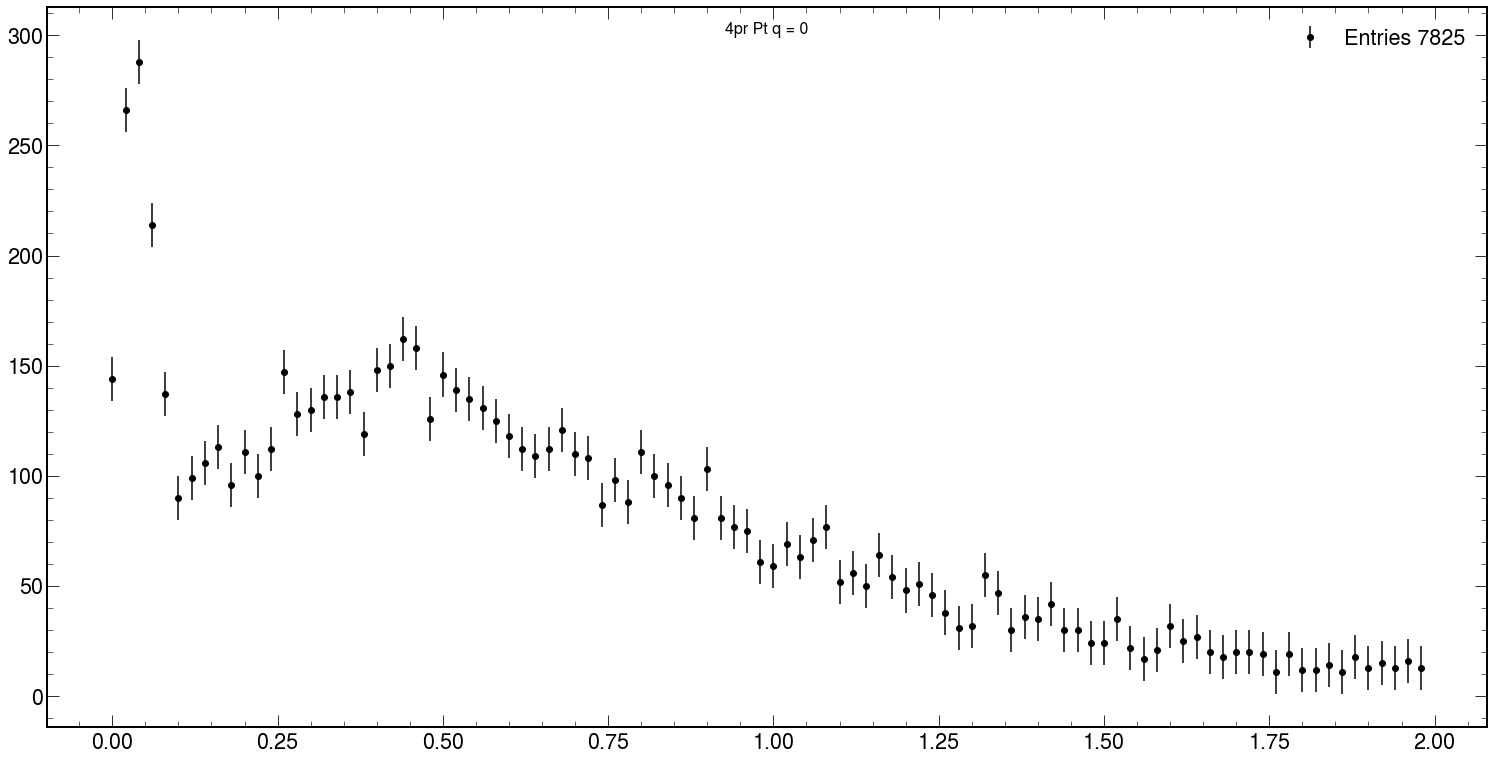

In [434]:
pxg = px[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)
pyg = py[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)
goodCharges = q[GoodEventsNumber][select[np.sum(select,axis=1)==4,:]].reshape(len(GoodEventsNumber),4)
goodChargesEventNumbers = np.argwhere(np.sum(goodCharges,axis=1)==0)
ptMy = np.sqrt(np.sum(np.add(np.sum(pxg[goodChargesEventNumbers], axis=2)**2, np.sum(pyg[goodChargesEventNumbers], axis=2)**2),axis=1))
counts, bins = np.histogram(ptMy,bins=100, range=(0,2))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr Pt q = 0', fontsize=16)
plt.style.use(hep.style.ROOT)
ax.errorbar(bins[:-1],counts, 10 * counts // counts,fmt='o', color='black',label=f'Entries {np.sum(counts)}')
ax.legend()

## DRAFTS

In [333]:
nTrack = 7
allData = np.concatenate(
    (
        px[:,nTrack].reshape(entries,1),
        py[:,nTrack].reshape(entries,1),
        pz[:,nTrack].reshape(entries,1), 
        itsl0[:,nTrack].reshape(entries,1),
        itsl1[:,nTrack].reshape(entries,1),
        tpcref[:,nTrack].reshape(entries,1),
        itcref[:,nTrack].reshape(entries,1),
        dca0[:,nTrack].reshape(entries,1),
        dca1[:,nTrack].reshape(entries,1),
        tpcncls[:,nTrack].reshape(entries,1),
        sigmtpcpion[:,nTrack].reshape(entries,1)
   ),
    axis=1)
df = ps.DataFrame(allData, columns=['px', 'py', 'pz', 'itsl0', 'itsl1', 'tpcref', 'itcref', 'dca0', 'dca1', 'tpcncls', 'sigmtpcpion' ])

df[(df.itsl1 == 1) * (df.itsl0 == 1) * (df.tpcref > 0) * (df.itcref > 0) * ((np.abs(df.dca0) < 3) + (np.abs(df.dca1) < 3)) * (df.tpcncls > 50) * (np.abs(df.sigmtpcpion) < 3)]



,px,py,pz,itsl0,itsl1,tpcref,itcref,dca0,dca1,tpcncls,sigmtpcpion
92,-0.235169,-0.370390,0.282769,1.0,1.0,64.0,4.0,-0.031666,0.014889,147.0,1.014219
322,0.208089,0.121501,-0.137248,1.0,1.0,64.0,4.0,-0.992071,1.577048,150.0,1.218733
369,-0.239458,0.067547,0.227688,1.0,1.0,64.0,4.0,0.025125,-0.042905,111.0,0.992132
389,0.204551,-0.137288,-0.008998,1.0,1.0,64.0,4.0,-0.021877,0.049673,122.0,-2.037001
718,-0.220457,-0.214724,0.005247,1.0,1.0,64.0,4.0,-0.012553,-0.049239,111.0,-1.652517
751,0.102243,-0.271302,-0.254369,1.0,1.0,64.0,4.0,-0.045375,-0.025979,137.0,0.577137
809,0.029726,-0.604194,0.076040,1.0,1.0,64.0,4.0,0.000120,-0.004709,121.0,0.130963
919,-0.097871,0.199842,-0.137984,1.0,1.0,64.0,4.0,-0.054316,0.026211,150.0,-0.069605
1128,0.354434,-0.267449,0.394892,1.0,1.0,64.0,4.0,-0.025528,-0.021843,142.0,0.713147
1152,0.363052,0.162438,0.338284,1.0,1.0,64.0,4.0,-0.021614,-0.019710,150.0,2.440457


In [1]:
from ROOT import TCanvas

Welcome to JupyROOT 6.20/04
